### Введение

Прочитав две статьи о подходе к определению стоимость биткоина и попытке понять является ли текущая стоимость раздутой, 
я решил перепроверить методику и сделать собственные выводы.

В статье __[Introducing NVT Ratio (Bitcoin's PE Ratio), use it to detect bubbles](http://woobull.com/introducing-nvt-ratio-bitcoins-pe-ratio-use-it-to-detect-bubbles/)__
описан сам подход. А в статье __[Rethinking Network Value to Transactions (NVT) Ratio](https://medium.com/cryptolab/https-medium-com-kalichkin-rethinking-nvt-ratio-2cf810df0ab0)__ сделана попытка уточнить метрику.

### Цель исследования

Меня смутили, в первую очередь, заданные авторами обеих статей диапазоны колебания метрики, которые определны, как "зелёная зона", "жёлтая зона" и "красная зона". В своём исследовании мне хотелось бы понять, как эти диапазоны вычислялись, валидно ли вообще это исследование или это лишь попытка убедить читателей в качестве "новой" метрики при помощи манипуляции средствами визуализации.    

Для построения метрики нам понадобятся ежесуточные данные о рыночной капитализации и суммарной стоимости транзакций в сети. Чтобы сравнение получилось достаточно детальным, планируется взять данные из 2х источников:
* blockchain.info
* coinmetrics.io


### Данные blockchain.info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pprint import pprint
from matplotlib.patches import Rectangle
from IPython.display import Math
from functools import partial

In [2]:
market_cap_json = requests.get('https://api.blockchain.info/charts/market-cap?timespan=all&format=json')

Перед тем, как строить *DataFrame* имеет смысл ознакомиться со структурой полученных данных.

In [3]:
pprint(market_cap_json.json(), depth=1)

{'description': 'The total USD value of bitcoin supply in circulation, as '
                'calculated by the daily average market price across major '
                'exchanges.',
 'name': 'Market Capitalization',
 'period': 'day',
 'status': 'ok',
 'unit': 'USD',
 'values': [...]}


Нам нужны данные, которые содержатся по ключу *values*. Заглянем глубже.

In [4]:
pprint(market_cap_json.json()['values'][0:5])

[{'x': 1230940800, 'y': 0.0},
 {'x': 1231113600, 'y': 0.0},
 {'x': 1231286400, 'y': 0.0},
 {'x': 1231459200, 'y': 0.0},
 {'x': 1231632000, 'y': 0.0}]


Отлично! По ключу *'x'* в списке находится *timestamp*, а по ключу *'y'* - усреднённая ежедневная цена одного биткоина в долларах. Для дальнейшей работы с этими данными нам необходимо построить *DataFrame*, присвоить столбцам подходящие имена и трансформировать *timestamp* из *int* в *datetime*.

In [5]:
market_cap = pd.DataFrame(market_cap_json.json()['values']).rename(columns={'x':'date', 'y':'market_cap'})
market_cap = market_cap.assign(date=lambda df: pd.to_datetime(df['date'], unit='s')).set_index('date')

Ознакомимся со сводной информацией по таблице, чтобы удостовериться, что типы столбцов *DatetimeIndex* - для дат и *float* - для *market_cap*, и выяснить, есть ли в данных пропущенные значения. 

In [6]:
print(market_cap.info(null_counts=True))
print(market_cap.head(5))
print(market_cap.tail(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1669 entries, 2009-01-03 to 2018-02-21
Data columns (total 1 columns):
market_cap    1669 non-null float64
dtypes: float64(1)
memory usage: 26.1 KB
None
            market_cap
date                  
2009-01-03         0.0
2009-01-05         0.0
2009-01-07         0.0
2009-01-09         0.0
2009-01-11         0.0
              market_cap
date                    
2018-02-13  1.449868e+11
2018-02-15  1.682865e+11
2018-02-17  1.829154e+11
2018-02-19  1.874982e+11
2018-02-21  1.777823e+11


Всё хорошо, однако, даты в полученном с сайта файле идут не подряд, а через день. Т.к. дальнейший анализ потребует усреднения данных по периодам в n-дней, то имеет смысл увеличить дискретизацию до дней. При добавлении пропущенных дней заполним отсутствующие значения предыдущими.

In [8]:
market_cap = market_cap.resample('1D').fillna(method='ffill')
print(market_cap.head())
print(market_cap.tail())

            market_cap
date                  
2009-01-03         0.0
2009-01-04         0.0
2009-01-05         0.0
2009-01-06         0.0
2009-01-07         0.0
              market_cap
date                    
2018-02-17  1.829154e+11
2018-02-18  1.829154e+11
2018-02-19  1.874982e+11
2018-02-20  1.874982e+11
2018-02-21  1.777823e+11


После того, как были проведены все трансформации, файл был сохранён в csv. Для целей воспроизводимости файл с данными приложен к notebook'у.

In [9]:
market_cap = pd.read_csv('blockchain_info_market_cap_21-02-2018.csv').assign(date=lambda df: pd.to_datetime(df['date'])).set_index('date')

Предлагаю взлянуть на данные, построив такой же график, как и на сайте-источнике. Необходимости делать детальную и интерактивную  визуализацию, пока что, нет. Ограничимся статичной картинкой.

In [10]:
def format_date_axis(axis_obj):
    axis_obj.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axis_obj.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))


def format_price_axis(axis_obj, log_scale):
    if log_scale:
        axis_obj.set_yscale('log')
        axis_obj.yaxis.set_major_formatter(ticker.ScalarFormatter())

    axis_obj.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


def make_single_ts_plot(dates,
                        data_points,
                        title,
                        ylabel,
                        size=[15, 9],
                        y_log_scale=False):
    plt.plot(dates, data_points)
    ax = plt.gca()
    format_date_axis(ax)
    format_price_axis(ax, y_log_scale)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.rcParams["figure.figsize"] = size
    plt.tight_layout()
    return plt, ax

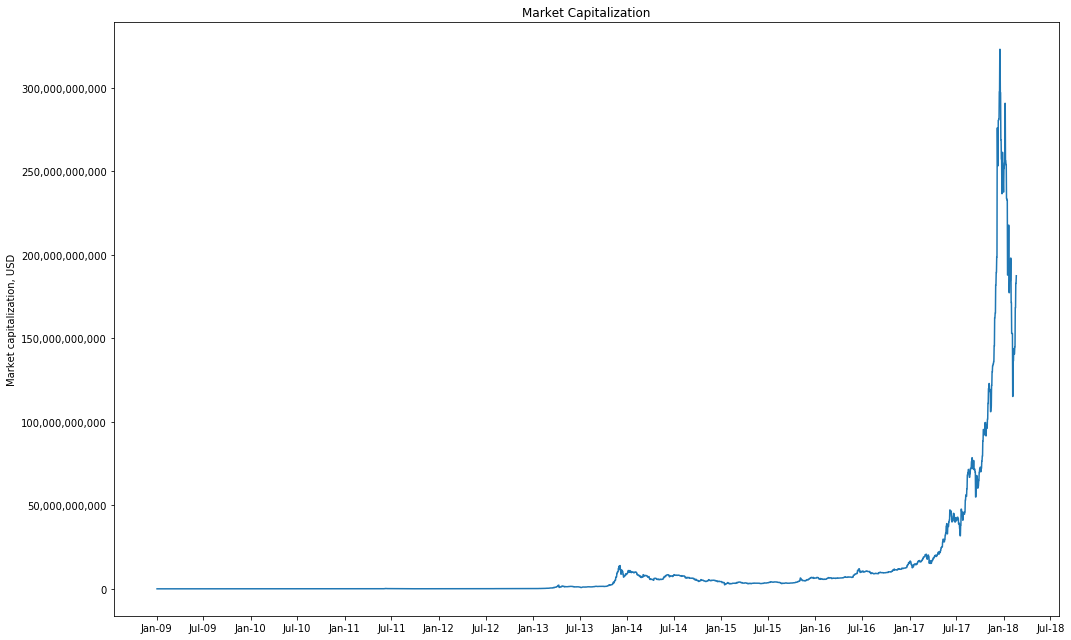

In [12]:
plt, ax = make_single_ts_plot(dates=market_cap.index,
                              data_points=market_cap.market_cap,
                              title='Market Capitalization',
                              ylabel='Market capitalization, USD',
                              y_log_scale=False)
plt.show()

Проведём аналогичную подготовку данных для суммарной стоимости транзакций в сети.

In [13]:
estimated_transaction_value_json = requests.get('https://api.blockchain.info/charts/estimated-transaction-volume-usd?timespan=all&format=json')
pprint(estimated_transaction_value_json.json(), depth=1)
pprint(market_cap_json.json()['values'][0:5])

{'description': 'The Estimated Transaction Value in USD value.',
 'name': 'Estimated USD Transaction Value',
 'period': 'day',
 'status': 'ok',
 'unit': 'USD',
 'values': [...]}
[{'x': 1230940800, 'y': 0.0},
 {'x': 1231113600, 'y': 0.0},
 {'x': 1231286400, 'y': 0.0},
 {'x': 1231459200, 'y': 0.0},
 {'x': 1231632000, 'y': 0.0}]


Структура данных та же, что и в предыдущем наборе.

In [14]:
estimated_transaction_value = pd.DataFrame(estimated_transaction_value_json.json()['values']).rename(columns={'x':'date', 'y':'usd_value'})
estimated_transaction_value = estimated_transaction_value.assign(date=lambda df: pd.to_datetime(df['date'], unit='s')).set_index('date')

Несмотря на то, что данные, как и прежде, аггрегированы за двое суток, для оценки скользящего среднего подойдёт такой же подход к увеличению дискретности, как и в предыдущем случае.

Прочитаем ранее загруженные и подготовленные данные.

In [15]:
estimated_transaction_value = (pd
                               .read_csv('blockchain_info_estimated_transaction_value_21-02-2018.csv')
                               .assign(date=lambda df: pd.to_datetime(df['date'])).set_index('date'))

Построим график.

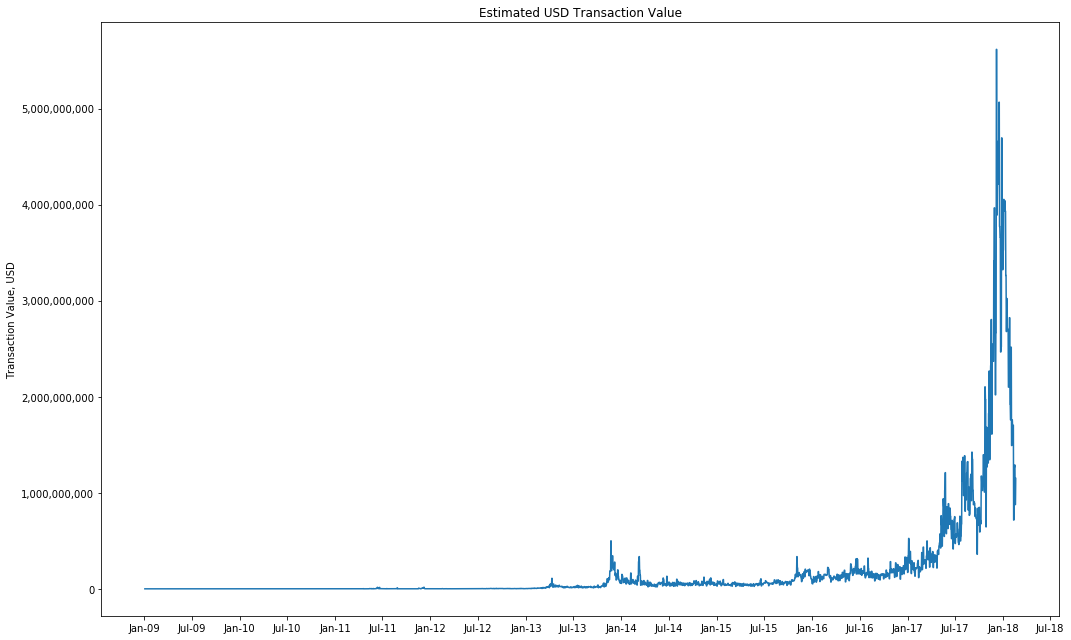

In [16]:
plt, ax = make_single_ts_plot(dates=estimated_transaction_value.index,
                              data_points=estimated_transaction_value.tx_volume,
                              title='Estimated USD Transaction Value',
                              ylabel='Transaction Value, USD',
                              y_log_scale=False)
plt.show()

### Новый NVT
Начнём с нового NVT, ведь статья о нём и явилась причиной начала этого исследования.

В комментарии __[...congratulations for this amazing study!](https://medium.com/@l.ghidinelli/hi-dmitry-kalichkin-congratulations-for-this-amazing-study-dc66aad95e46)__ Дмитрий Каличкин даёт следующее разъяснение о формуле расчёта:

_Use daily Network Value (aka Market Cap) in numerator, and 90 day avg Tx volume (USD) in denominator. ..._

Кроме того, исходная метрика рассчитывалась путём сглаживания данных за 14 дней до рассматриваемой даты и на 14 дней вперёд. Чтобы избавиться от необходимости ждать 14 (или n) дней, автор статьи прешёл в расчёт среднего за 90 дней _до_ рассматриваемой даты:

* _Why 14 days forward and backward? If we are trying to develop a predictive, or at least descriptive, indicator we shouldn’t rely on future data._
* _... when we move from a 28-day Moving Average to a 90-day Moving Average NVT definition, we get rid of the time lag issue described above._


\begin{align}
NVT\_new = \frac{Daily NV}{90MA(Daily TV)}\\
\end{align}

In [17]:
estimated_transaction_value['MA90_tx_vol'] = estimated_transaction_value['tx_volume'].rolling(window=90, min_periods=1).mean()
blockchain_NVT_data = (pd
                       .concat([market_cap, estimated_transaction_value[['tx_volume', 'MA90_tx_vol']]], axis=1)
                       .assign(NVTnew=lambda df: df.market_cap/df.MA90_tx_vol))

На иллюстрации из статьи видно, что диапазон задан с июля 2013 года по конец 2017г.

![График из статьи](https://cdn-images-1.medium.com/max/800/1*Ijoy_dgADr4VfIjjpm9BMA.png)

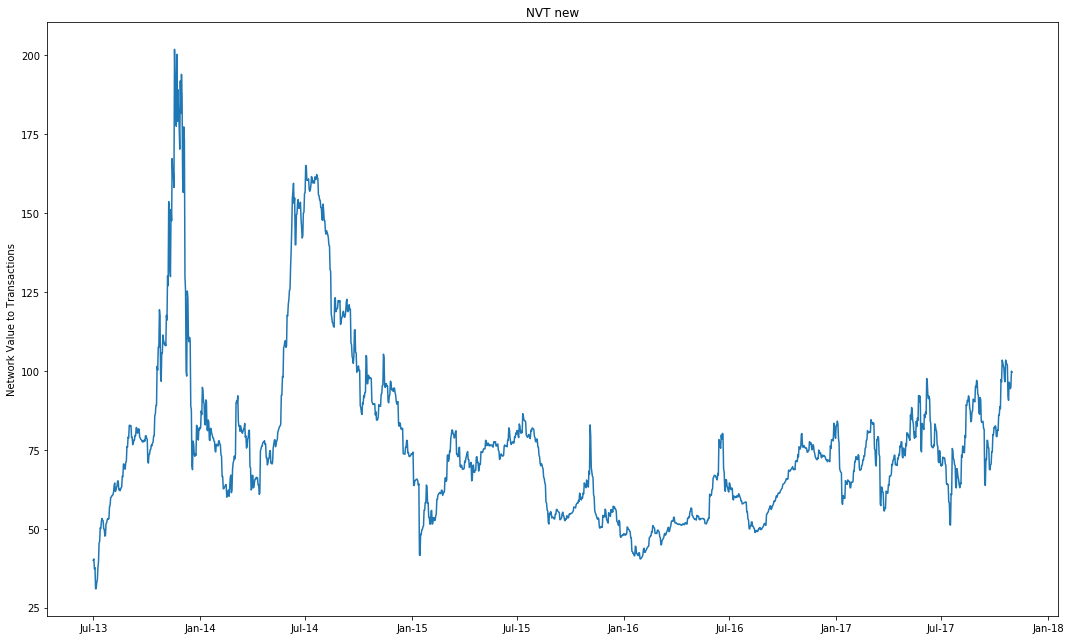

In [18]:
plt, ax = make_single_ts_plot(dates=blockchain_NVT_data['2013-07':'2017-10'].index,
                              data_points=blockchain_NVT_data.NVTnew['2013-07':'2017-10'],
                              title='NVT new',
                              ylabel='Network Value to Transactions',
                              y_log_scale=False)
plt.show()

Кривая на графике и, самое главное, диапазон её изменения очень сильно отличаются от того, что рассматривается в статье.
Так, кривая на графике в статье колеблется от 5 до, примерно, 52. В полученном же графике диапазон колебания, примерно, от 30 до 200.
Возможно, дело в источнике данных. Попробуем наложить на полученный график цену биткоина за этот временной период.

In [19]:
usd_price_json = requests.get('https://api.blockchain.info/charts/market-price?timespan=all&format=json')
pprint(usd_price_json.json(), depth=1)

{'description': 'Average USD market price across major bitcoin exchanges.',
 'name': 'Market Price (USD)',
 'period': 'day',
 'status': 'ok',
 'unit': 'USD',
 'values': [...]}


In [20]:
usd_price = pd.DataFrame(usd_price_json.json()['values']).rename(columns={'x':'date', 'y':'usd_price'})
usd_price = (usd_price
             .assign(date=lambda df: pd.to_datetime(df['date'], unit='s'))
             .set_index('date')
             .resample('1D').fillna(method='ffill'))

Как и прежде, для целей воспроизводимости, данные будут загружены из приложенного файла.

In [21]:
blockchain_usd_price = (pd
                        .read_csv('blockchain_info_usd_price-21-02-2018.csv')
                        .assign(date=lambda df: pd.to_datetime(df['date'])).set_index('date')
                        .resample('1D').fillna(method='ffill'))

Функция ниже позволяет построить график с двумя шкалами по оси ординат, одна из которых может быть отображена в логарифмическом масштабе. 
Функция позволяет дополнять график аннотациями и дополнительными кривыми, что понадобится дальше.

In [22]:
def make_double_axis_ts_plot(date_axis,
                             ts_1,
                             ts_1_legend_label,
                             ts_1_ylabel,
                             ts_1_lt,
                             ts_1_lw,
                             ts_1_ylogscale,
                             ts_2,
                             ts_2_lt,
                             ts_2_lw,
                             ts_2_legend_label,
                             ts_2_ylabel,
                             title,
                             size=[15, 9],
                             ts1_arbitrary_plotting=None,
                             ts2_arbitrary_plotting=None):
    fig, ax1 = plt.subplots(figsize=size)

    if ts1_arbitrary_plotting:
        ts1_arbitrary_plotting(ax1)

    ax1.plot(date_axis,
             ts_1,
             ts_1_lt,
             lw=ts_1_lw,
             label=ts_1_legend_label)
    ax1.set_ylabel(ts_1_ylabel)

    format_date_axis(ax1)
    format_price_axis(ax1, ts_1_ylogscale)

    ax2 = ax1.twinx()

    if ts2_arbitrary_plotting:
        ts2_arbitrary_plotting(ax2)

    ax2.plot(date_axis,
             ts_2,
             ts_2_lt,
             lw=ts_2_lw,
             label=ts_2_legend_label)
    ax2.set_ylabel(ts_2_ylabel)

    plt.title(title)
    ax1_legend = ax1.legend(loc=4, bbox_to_anchor=(0.85, 0))
    ax2_legend = ax2.legend(loc=4, bbox_to_anchor=(0.95, 0))
    ax1_legend.get_frame().set_linewidth(0.0)
    ax2_legend.get_frame().set_linewidth(0.0)
    fig.tight_layout()
    return plt, fig, ax1, ax2

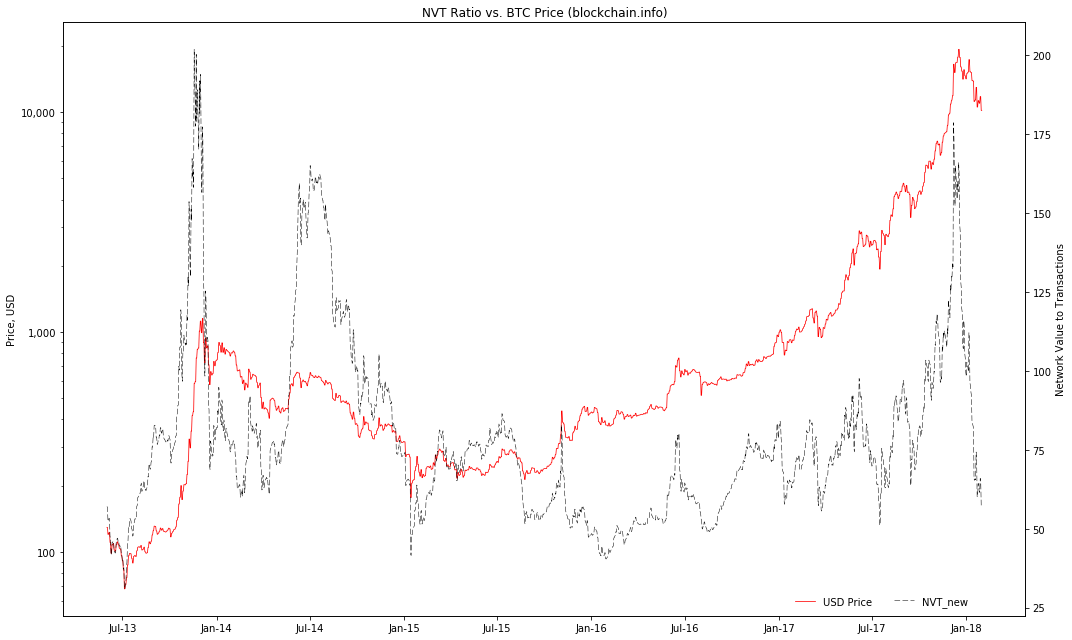

In [23]:
plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=blockchain_usd_price['2013-06':'2018-01'].index,
                                              ts_1=blockchain_usd_price.usd_price['2013-06':'2018-01'],
                                              ts_1_legend_label="USD Price",
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_ylabel='Price, USD',
                                              ts_1_ylogscale=True,
                                              ts_2=blockchain_NVT_data.NVTnew['2013-06':'2018-01'],
                                              ts_2_legend_label="NVT_new",
                                              ts_2_lt='k--',
                                              ts_2_lw=0.5,
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='NVT Ratio vs. BTC Price (blockchain.info)')
plt.show()

В то время, как полученный график по-прежнему отличается от иллюстрации из статьи, тем не менее пики NVT_new в некоторой степени поддерживают гипотезу автора: последний пик, как раз, произошёл перед падением цены в начале года.

Следующим шагом нужно определить, какое значение является "нормальным" (зелёного цвета на иллюстрации), а какие - нет (жёлтые и красные области.

Автор на этот счёт в комментарии __[How to assign color codes to specific bands of NVT levels?](https://medium.com/@dbektemissov/how-do-you-decide-how-to-assign-color-codes-to-specific-bands-of-ntv-levels-green-yellow-red-668b10374ed4)__ сообщает, что диапазоны заданы "эмпирическим путём" и достаточной теоретической основы для них нет:

_... we are thinking about how we could apply more fundamental thinking here, but as of now I don’t have a strong theory to suggest on this front._


Воспользуемся подходом Jenks Natural Breaks Optimization из статьи __[Literate Jenks Natural Breaks and How The Idea Of Code is Lost](https://macwright.org/2013/02/18/literate-jenks.html)__. Суть подхода сводится к тому, чтобы для выборки оптимально подобрать границы для N диапазонов внутри этой выборки.
Cython имплементация взята __[отсюда](https://github.com/perrygeo/jenks)__.

In [24]:
from jenks import jenks as get_jenks_breaks

In [25]:
nvt_breaks = get_jenks_breaks(blockchain_NVT_data.NVTnew['2013-06':'2018-01'].values, 3)

In [26]:
print(nvt_breaks)

[30.963764, 69.330765, 112.29003, 201.82626]


In [27]:
def add_nvt_ranges(axis_object, breaks, x0, width):
    for br in breaks:
        axis_object.add_patch(Rectangle((x0, br['y0']), width, br['height'], color=br['color'], alpha=0.15))

In [28]:
breaks = list(map(int, nvt_breaks))
jenks_breaks = [{'y0': breaks[0], 'height': breaks[1] - breaks[0], 'color': 'green'},
                {'y0': breaks[1], 'height': breaks[2] - breaks[1], 'color': 'yellow'},
                {'y0': breaks[2], 'height': breaks[3] - breaks[2], 'color': 'red'}]

add_jenks_ranges = partial(add_nvt_ranges,
                           breaks=jenks_breaks,
                           x0=mdates.date2num(blockchain_usd_price['2013-06'].index[0]),
                           width=blockchain_usd_price['2013-06':'2018-01'].index.shape[0])

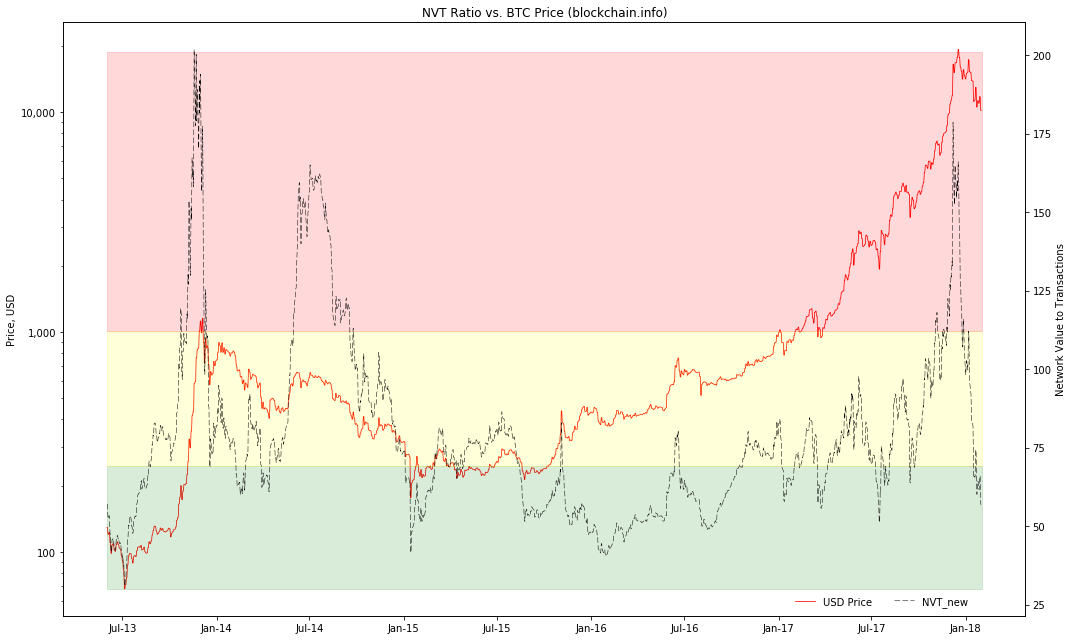

In [29]:
plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=blockchain_usd_price['2013-06':'2018-01'].index,
                                              ts_1=blockchain_usd_price.usd_price['2013-06':'2018-01'],
                                              ts_1_legend_label="USD Price",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_ylogscale=True,
                                              ts_2=blockchain_NVT_data.NVTnew['2013-06':'2018-01'],
                                              ts_2_lt='k--', 
                                              ts_2_lw=0.5,
                                              ts_2_legend_label="NVT_new",
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='NVT Ratio vs. BTC Price (blockchain.info)',
                                              ts2_arbitrary_plotting=add_jenks_ranges)
plt.show()

К сожалению, цветовые регионы не добавляют понимания... Попробуем вручную разместить цветовые диапазоны. Смысла в этом особенного нет, но в качестве упражнения в манипулятивных приёмах визуализации сойдёт.

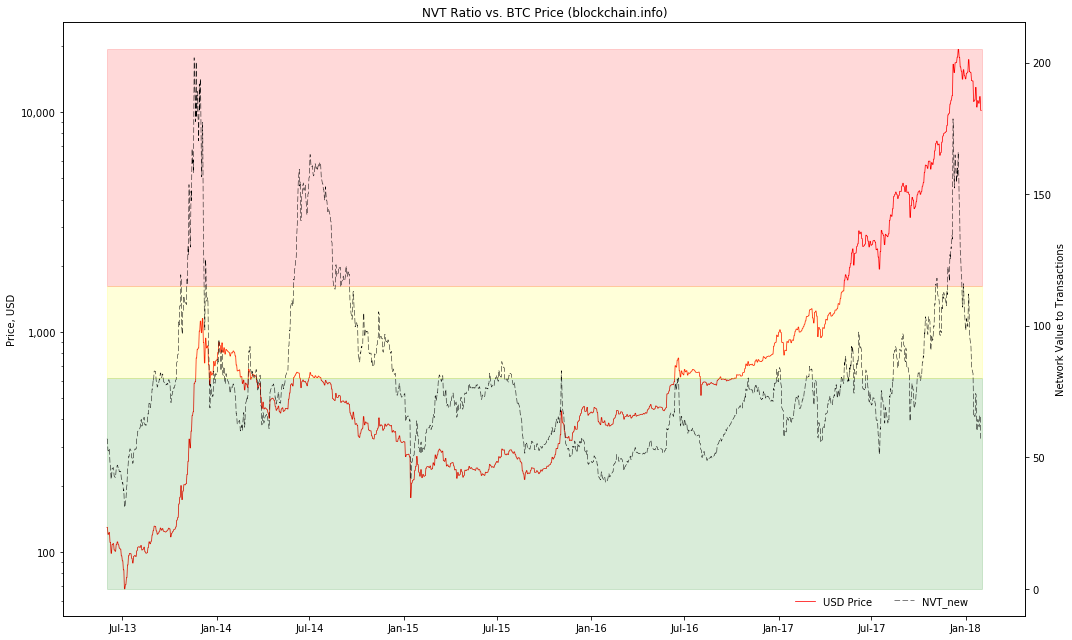

In [30]:
article_breaks = [{'y0': 0, 'height': 80, 'color': 'green'},
                  {'y0': 80, 'height': 35, 'color': 'yellow'},
                  {'y0': 115, 'height': 90, 'color': 'red'}]

add_article_ranges = partial(add_nvt_ranges,
                             breaks=article_breaks,
                             x0=mdates.date2num(blockchain_usd_price['2013-06'].index[0]),
                             width=blockchain_usd_price['2013-06':'2018-01'].index.shape[0])

plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=blockchain_usd_price['2013-06':'2018-01'].index,
                                              ts_1=blockchain_usd_price.usd_price['2013-06':'2018-01'],
                                              ts_1_legend_label="USD Price",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_ylogscale=True,
                                              ts_2=blockchain_NVT_data.NVTnew['2013-06':'2018-01'],
                                              ts_2_legend_label="NVT_new",
                                              ts_2_lt='k--', 
                                              ts_2_lw=0.5,
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='NVT Ratio vs. BTC Price (blockchain.info)',
                                              ts2_arbitrary_plotting=add_article_ranges)
plt.show()

### Данные blockchain.info
Попробуем провести тот же анализ только на данных с *coinmetrics*.

In [31]:
coinmetrics_btc = pd.read_csv(
    'https://coinmetrics.io/data/btc.csv', 
    index_col=False, 
    header=None, 
    names=['date', 'txVolume', 'txCount', 'marketcap', 'price', 'exchangeVolume','generatedCoins', 'fees'], 
    skiprows=1)
coinmetrics_btc = coinmetrics_btc.assign(date=lambda df: pd.to_datetime(df.date)).set_index('date')
# coinmetrics_btc.to_csv('coinmetrics_data_22-02-2018.csv')
print(coinmetrics_btc.head(2))

                txVolume  txCount     marketcap   price  exchangeVolume  \
date                                                                      
2013-05-01  1.086597e+08    52443  1.542820e+09  139.00             0.0   
2013-05-02  9.695852e+07    55169  1.292190e+09  116.38             0.0   

            generatedCoins       fees  
date                                   
2013-05-01          3575.0  36.806000  
2013-05-02          3425.0  54.407916  


Для воспроизводимости, загружаем данные из приложенного файла.

In [32]:
coinmetrics_btc = pd.read_csv('coinmetrics_data_22-02-2018.csv').assign(date=lambda df: pd.to_datetime(df.date)).set_index('date')

С полученными данными можно практически сразу выстроить метрику.

In [33]:
coinmetrics_btc['MA90_tx_vol'] = coinmetrics_btc['txVolume'].rolling(window=90, min_periods=1).mean()
coinmetrics_btc = coinmetrics_btc.assign(NVTnew=lambda df: df['marketcap']/df.MA90_tx_vol)

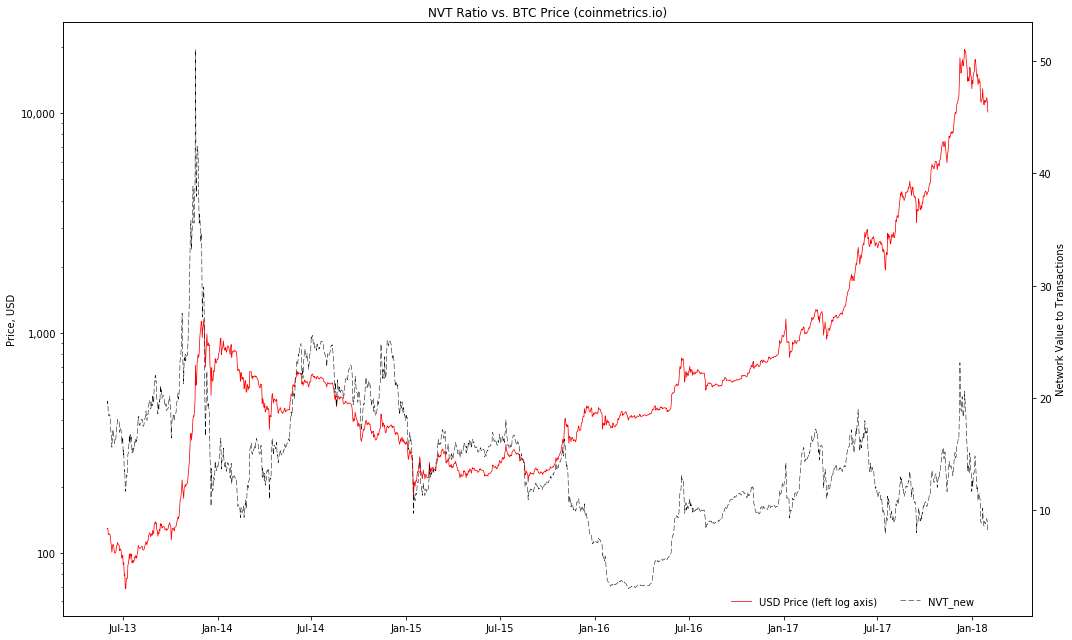

In [34]:
plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=coinmetrics_btc['2013-06':'2018-01'].index,
                                              ts_1=coinmetrics_btc.price['2013-06':'2018-01'],
                                              ts_1_legend_label="USD Price (left log axis)",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_ylogscale=True,
                                              ts_2=coinmetrics_btc.NVTnew['2013-06':'2018-01'],
                                              ts_2_legend_label="NVT_new",
                                              ts_2_lt='k--', 
                                              ts_2_lw=0.5,
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='NVT Ratio vs. BTC Price (coinmetrics.io)')
plt.show()

Данные *coinmetrics.io* позволяют пострить более похожий на иллюстрацию в статье график. Добавим цветовых диапазонов и линий.

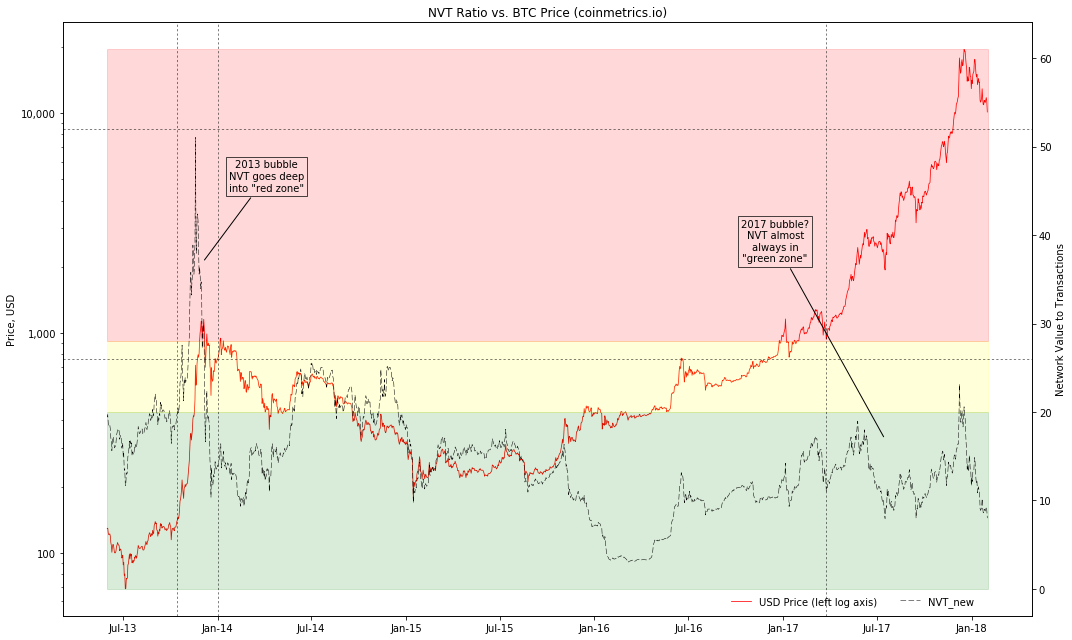

In [35]:
figure_breaks = [{'y0': 0, 'height': 20, 'color': 'green'},
                 {'y0': 20, 'height': 8, 'color': 'yellow'},
                 {'y0': 28, 'height': 33, 'color': 'red'}]

add_article_ranges = partial(add_nvt_ranges,
                             breaks=figure_breaks,
                             x0=mdates.date2num(coinmetrics_btc['2013-06'].index[0]),
                             width=coinmetrics_btc['2013-06':'2018-01'].index.shape[0])

plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=coinmetrics_btc['2013-06':'2018-01'].index,
                                              ts_1=coinmetrics_btc.price['2013-06':'2018-01'],
                                              ts_1_legend_label="USD Price (left log axis)",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_ylogscale=True,
                                              ts_2=coinmetrics_btc.NVTnew['2013-06':'2018-01'],
                                              ts_2_legend_label="NVT_new",
                                              ts_2_lt='k--', 
                                              ts_2_lw=0.5,
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='NVT Ratio vs. BTC Price (coinmetrics.io)',
                                              ts2_arbitrary_plotting=add_article_ranges)

ax2.axvline(x=mdates.date2num(coinmetrics_btc['2014-01'].index[0]), linewidth=0.5, color='k', ls=':')
ax2.axvline(x=mdates.date2num(coinmetrics_btc['2013-10'].index[14]), linewidth=0.5, color='k', ls=':')
ax2.axvline(x=mdates.date2num(coinmetrics_btc['2017-03'].index[24]), linewidth=0.5, color='k', ls=':')
ax2.axhline(y=52, linewidth=0.5, color='k', ls=':')
ax2.axhline(y=26, linewidth=0.5, color='k', ls=':')

ax2.annotate('2013 bubble\nNVT goes deep\ninto "red zone"',
             xy=(coinmetrics_btc['2013-12'].index[3], 37),
             xytext=(coinmetrics_btc['2014-04'].index[5], 45),
             horizontalalignment='center',
             arrowprops=dict(arrowstyle="-", color='black'),
             bbox=dict(boxstyle="square, pad=0.3", fc='none', alpha=1, lw=0.7, edgecolor='black'))

ax2.annotate('2017 bubble?\nNVT almost\nalways in\n"green zone"',
             xy=(coinmetrics_btc['2017-07'].index[15], 17),
             xytext=(coinmetrics_btc['2016-12'].index[15], 37),
             horizontalalignment='center',
             arrowprops=dict(arrowstyle="-", color='black'),
             bbox=dict(boxstyle="square, pad=0.3", fc='none', alpha=1, lw=0.7, edgecolor='black'))
plt.show()

Выглядит похоже.

![График из статьи](https://cdn-images-1.medium.com/max/800/1*Ijoy_dgADr4VfIjjpm9BMA.png)

Шутки в сторону. 
Очевидно, что данные из двух источников значительно отличаются - это отразилось на диапазонах NVT_new. 

### Классический NVT

Для исходной метрики потребуется 28-ми дневное скользящее среднее, рассчитанное за 14 дней до и на 14 дней после рассматриваемой даты.

\begin{align}
NVT\_classic = 28MA(\frac{Daily NV}{Daily TV})\\
\end{align}

In [36]:
def rolling_mean(ts, window, min_periods):
    return ts.rolling(window=window, min_periods=min_periods).mean()


def f_rolling_mean(ts, window, min_periods):
    return rolling_mean(ts[::-1], window, min_periods)[::-1]


def two_directional_rolling_mean(ts, window, min_periods):
    assert window % 2 == 0, 'Window must be divisible by 2.'
    split_window = lambda x: int(x / 2)
    return (rolling_mean(ts, split_window(window), min_periods)
            .add(f_rolling_mean(ts, split_window(window), min_periods))
            .divide(2))

coinmetrics_btc['28MA_marketcap'] = two_directional_rolling_mean(coinmetrics_btc['marketcap'], window=28, min_periods=0)
coinmetrics_btc['28MA_txVolume'] = two_directional_rolling_mean(coinmetrics_btc['txVolume'], window=28, min_periods=0)
coinmetrics_btc['NVT_classic'] = coinmetrics_btc['28MA_marketcap'].divide(coinmetrics_btc['28MA_txVolume'])

Построим полученный график поверх уже построенных. Только на этот раз без цветных областей, т.к. в данном случае они будут сильно отвлекать, при этом, не неся смысловой нагрузки.

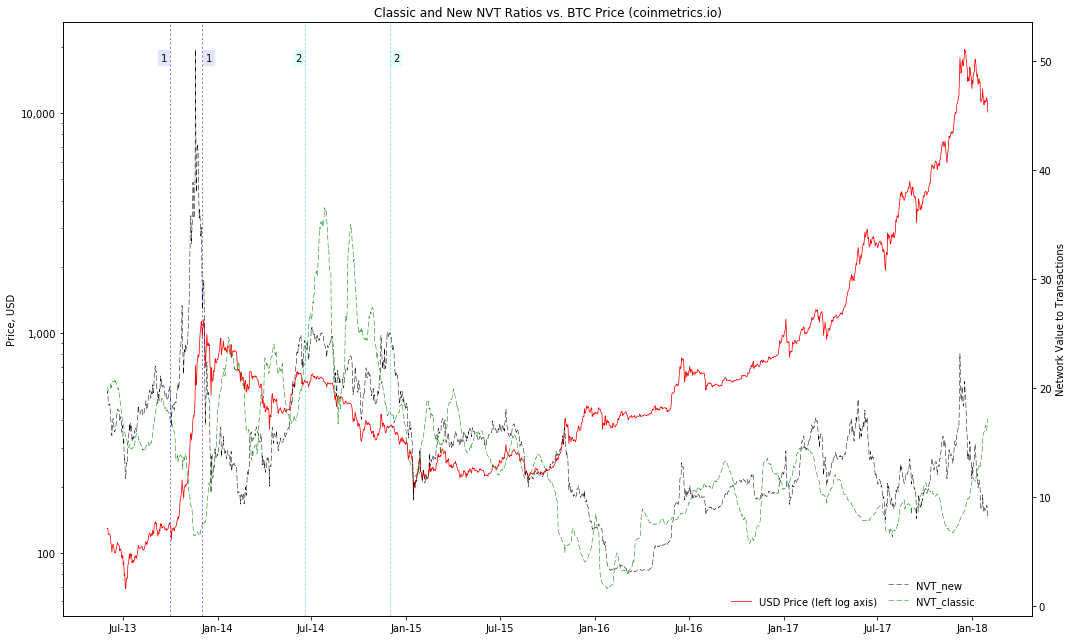

In [37]:
def add_plot(axis_obj):
    axis_obj.plot(coinmetrics_btc['2013-06':'2018-01'].index,
                  coinmetrics_btc.NVTnew['2013-06':'2018-01'],
                  'k--', lw=0.5, label="NVT_new")
def add_annotation(axis_obj, label, x, y, fc):
    axis_obj.annotate(label, xy=(x, y), 
             bbox=dict(boxstyle="square, pad=0.3", fc=fc, alpha=0.1, lw=0.1, edgecolor='black'))

def add_xvline(axis_obj, x, color):
    axis_obj.axvline(x=mdates.date2num(x), linewidth=0.5, color=color, ls=':')

plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=coinmetrics_btc['2013-06':'2018-01'].index,
                                              ts_1=coinmetrics_btc.price['2013-06':'2018-01'],
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_legend_label="USD Price (left log axis)",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_ylogscale=True,
                                              ts_2=coinmetrics_btc.NVT_classic['2013-06':'2018-01'],
                                              ts_2_lt='g--',
                                              ts_2_lw=0.5,
                                              ts_2_legend_label="NVT_classic",
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='Classic and New NVT Ratios vs. BTC Price (coinmetrics.io)',
                                              ts2_arbitrary_plotting=add_plot)


lines_lst = [(blockchain_usd_price['2013-10'].index[0], 'b'),
             (blockchain_usd_price['2013-12'].index[0], 'b'),
             (blockchain_usd_price['2014-06'].index[17], 'c'),
             (blockchain_usd_price['2014-12'].index[0], 'c')]

for item in lines_lst:
    add_xvline(ax2, item[0], item[1])

annotate = partial(add_annotation, axis_obj=ax2, y=50)
annot_lst = [('1', blockchain_usd_price['2013-09'].index[12], 'blue'),
             ('1', blockchain_usd_price['2013-12'].index[8], 'blue'),
             ('2', blockchain_usd_price['2014-06'].index[0], 'cyan'),
             ('2', blockchain_usd_price['2014-12'].index[5], 'cyan')]

for item in annot_lst:
    annotate(label=item[0], x=item[1], fc=item[2])
    
plt.show()

Видно, что NVT_classic смещён. 
На графике можно заметить некоторые особенности. Отметим, а в дальнейшем, вместе с аналогичными особенностями на графике, построенном на данных blockchain.info, разберём. Итак:
1. в левой части графика самый крупный пик NVT_new начинается гораздо раньше падения цены и растёт с 01 октября 2013г. до 1 декабря 2013г.;
2. NVT_classic начинает давать длительные пиковые значения с 20 марта 2014г. по декабрь 2014г. уже после начала падения цены, NVT_new в это время столь высоких значений не показывает ни до, ни в течение падения, однако цена падает гораздо ниже, чем после первого пика.

Действительно, выглядит так, как если бы новая метрика гораздо лучше описывала ценовые "пузыри".
Попробуем перенести модели на данных blockchain.info.

In [38]:
blockchain_NVT_data['28MA_marketcap'] = two_directional_rolling_mean(blockchain_NVT_data['market_cap'], window=28, min_periods=0)
blockchain_NVT_data['28MA_txVolume'] = two_directional_rolling_mean(blockchain_NVT_data['tx_volume'], window=28, min_periods=0)
blockchain_NVT_data['NVT_classic'] = blockchain_NVT_data['28MA_marketcap'].divide(blockchain_NVT_data['28MA_txVolume'])

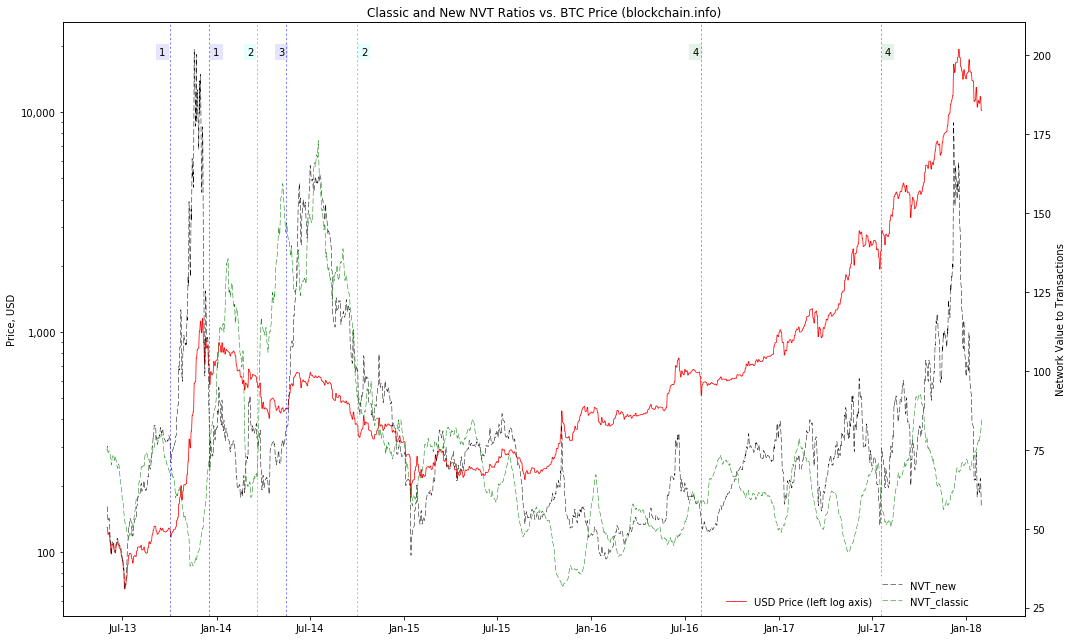

In [39]:
def add_plot(axis_obj):
    axis_obj.plot(blockchain_NVT_data['2013-06':'2018-01'].index,
                  blockchain_NVT_data.NVTnew['2013-06':'2018-01'],
                  'k--', lw=0.5, label="NVT_new")

plt, fig, ax1, ax2 = make_double_axis_ts_plot(date_axis=blockchain_usd_price['2013-06':'2018-01'].index,
                                              ts_1=blockchain_usd_price.usd_price['2013-06':'2018-01'],
                                              ts_1_lt='r-',
                                              ts_1_lw=0.75,
                                              ts_1_legend_label="USD Price (left log axis)",
                                              ts_1_ylabel='Price, USD',
                                              ts_1_ylogscale=True,
                                              ts_2=blockchain_NVT_data.NVT_classic['2013-06':'2018-01'],
                                              ts_2_lt='g--',
                                              ts_2_lw=0.5,
                                              ts_2_legend_label="NVT_classic",
                                              ts_2_ylabel='Network Value to Transactions',
                                              title='Classic and New NVT Ratios vs. BTC Price (blockchain.info)',
                                              ts2_arbitrary_plotting=add_plot)

lines_lst = [(blockchain_usd_price['2013-10'].index[0], 'b'),
             (blockchain_usd_price['2013-12'].index[15], 'b'),
             (blockchain_usd_price['2014-05'].index[15], 'b'),
             (blockchain_usd_price['2014-03'].index[20], 'c'),
             (blockchain_usd_price['2014-10'].index[0], 'c'),
             (blockchain_usd_price['2016-08'].index[0], 'g'),
             (blockchain_usd_price['2017-07'].index[18], 'g')]

for item in lines_lst:
    add_xvline(ax2, item[0], item[1])

annotate = partial(add_annotation, axis_obj=ax2, y=200)
annot_lst = [('1', blockchain_usd_price['2013-09'].index[10], 'blue'),
             ('1', blockchain_usd_price['2013-12'].index[24], 'blue'),
             ('2', blockchain_usd_price['2014-03'].index[0], 'cyan'),
             ('2', blockchain_usd_price['2014-10'].index[8], 'cyan'),
             ('3', blockchain_usd_price['2014-05'].index[0], 'blue'),
             ('4', blockchain_usd_price['2016-07'].index[15], 'green'), 
             ('4', blockchain_usd_price['2017-07'].index[25], 'green')]

for item in annot_lst:
    annotate(label=item[0], x=item[1], fc=item[2])

plt.show()

На этом графике видно, как и на предыдущих, что NVT_classic смещён. Очевидно, что активность (количество транзакций) коррелирует с колебаниями цены.
Однако, утверждать, что пики NVT предшствуют падениям не совсем правильно, на графиках есть тому подтверждения:
1. в левой части графика самый крупный пик NVT_new начинается гораздо раньше падения цены и растёт с 01 октября 2013г. до 1 декабря 2013г.;
2. NVT_classic даёт длительные пиковые значения с 20 марта 2014г. по октябрь 2014г. даже при росте цены;
3. NVT_new начинает показывает высокие значения начиная с 15 мая 2014 заканчивая октябрём 2014г., при этом, падение цены уже началось, т.е. метрика не предшествует падению;
4. Падения цены могут происходить и при относительно низком NVT_new.

Понять, когда наступит момент, после которого начнёт падать цена сложно, если вообще возможно.

Пики можно объяснить тем, что люди просто избавляются от своих биткоинов, тем самым создавая бОльшее количество транзакций, чем обычно. Ещё одной причиной пиков может быть то, что трейдеры, увидев восходящий тренд начинают проявлять бОльшую активность. А спады в NVT можно объяснить тем, что на падающем рынке люди начинают придерживаться стратегии "Hodl".

### Различия в данных
Внимателного читателя уже, скорее всего, посетила мысль о том, что все различия вызваны методологией аггрегации данных. Поэтому, обратимся к пояснениям из источников данных.

#### Определение *Price* 
>Price is price. Not much to say about that one. We get it from CoinMarketCap, with all the caveats that entails. _Be advised – it’s the opening price._

Различия состоят в разнице методологий сбора и агрегации данных:
* для blockchain.info price - это средняя рыночная цена в долларах США на ведущих биржах биткоинов;
* для coinmetrics - это цена открытия с CoinMarketCap;
* для __[CoinMarketCap](https://coinmarketcap.com/faq/)__ цена - *.. is .. the volume weighted average of all prices reported at each market*.

Сравним данные о рыночной капитализации и объёме транзакций.

In [40]:
comparison_df = (
    (blockchain_NVT_data
     .loc['2013-06':'2018-01', ['market_cap', 'tx_volume']]
     .rename(columns={'market_cap':'blockchain_mCap', 
                      'tx_volume':'blockchain_txVol'}))
    .join(
        (coinmetrics_btc
         .loc['2013-06':'2018-01', ['marketcap', 'txVolume']]
         .rename(columns={'marketcap':'coinmetrics_mCap', 
                          'txVolume':'coinmetrics_txVol'}))
    )
)

#### *Market Capitalization (USD)*
Обратимся к определениям, которые дают источники.

*Blockchain.info:*
>The total USD value of bitcoin supply in circulation. __[link](https://blockchain.info/charts/market-cap)__

Здесь всё понятно.

*Coinmetrics.io:*
>This is of course the unit price multiplied by the number of units in circulation.

Но есть уточнения.

>There has been quite a bit of controversy over this indicator. We still like __[this post](https://blog.sia.tech/want-to-deflate-the-token-bubble-fix-the-market-cap-indicator-d50f7f1e1ec4)__ from the Sia guys on the topic. Marketcap or network value is definitely flawed. It becomes less tethered to reality the smaller the float is. Float means the ratio of actual circulating units to the total number of units. Ripple, for instance, has a fairly small float, so one should probably be skeptical of its “market cap.”

График рыночной капитализации поможет выяснить существенны ли различия в данных между coinmetrics и blockchain.info.

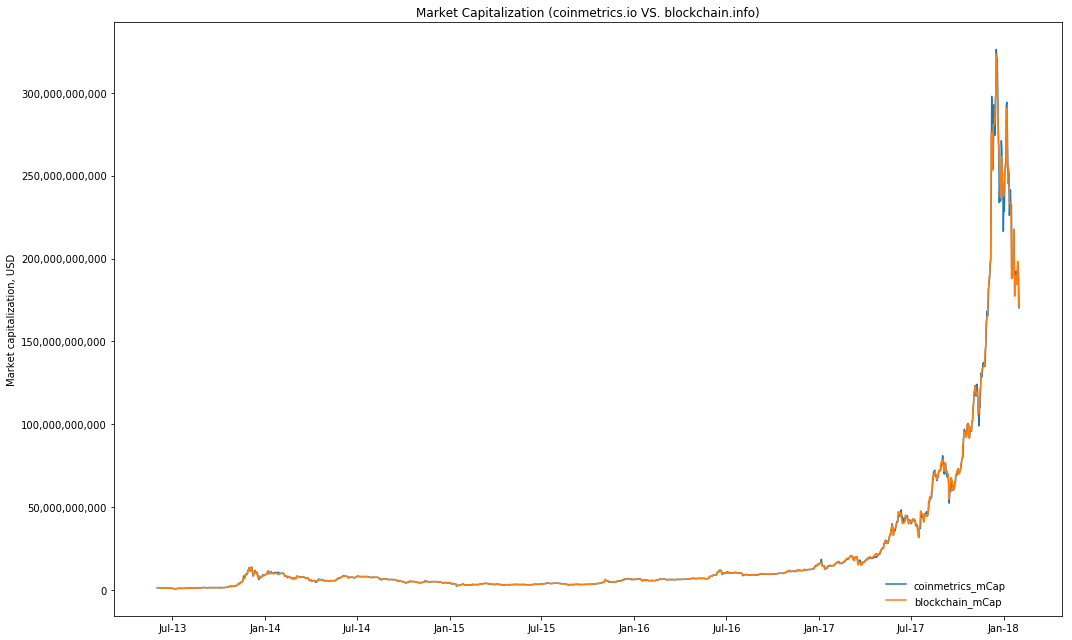

In [41]:
plt, ax = make_single_ts_plot(dates=comparison_df.index,
                              data_points=comparison_df.coinmetrics_mCap,
                              title='Market Capitalization (coinmetrics.io VS. blockchain.info)',
                              ylabel='Market capitalization, USD',
                              y_log_scale=False)
plt.plot(comparison_df.index, comparison_df.blockchain_mCap)
legend = ax.legend(loc=4, bbox_to_anchor=(0.95, 0))
legend.get_frame().set_linewidth(0.0)
plt.show()

Данные двух источников почти не отличаются. 

In [42]:
from sklearn.metrics import mean_squared_error
from numpy import mean, sqrt

prcnt_diff = round((mean(comparison_df.coinmetrics_mCap.divide(comparison_df.blockchain_mCap, fill_value=0))-1)*100, 2)
print('{}%'.format(prcnt_diff))

0.31%


0.31% составляет средняя разница между значениями двух графиков.

In [43]:
mCapRMSE = (comparison_df
            .assign(mCap_order = lambda df: df.coinmetrics_mCap.divide(df.blockchain_mCap, fill_value=0))
            .assign(mCap_Error = lambda df: df.coinmetrics_mCap - df.blockchain_mCap)
            .assign(mCap_SquaredError = lambda df: df.mCap_Error**2)
            .assign(mCap_RSE = lambda df: sqrt(df.mCap_SquaredError))
           )[['mCap_order', 'mCap_Error', 'mCap_SquaredError', 'mCap_RSE', 'coinmetrics_mCap', 'blockchain_mCap']]
print(mCapRMSE.head())
print(mean(mCapRMSE.mCap_order))
print(mean(mCapRMSE.mCap_RSE))

            mCap_order    mCap_Error  mCap_SquaredError      mCap_RSE  \
date                                                                    
2013-06-01    0.996673 -4.825585e+06       2.328627e+13  4.825585e+06   
2013-06-02    1.000899  1.304415e+06       1.701499e+12  1.304415e+06   
2013-06-03    1.020470  2.760478e+07       7.620236e+14  2.760478e+07   
2013-06-04    1.006262  8.444775e+06       7.131423e+13  8.444775e+06   
2013-06-05    0.991463 -1.175459e+07       1.381703e+14  1.175459e+07   

            coinmetrics_mCap  blockchain_mCap  
date                                           
2013-06-01      1.445800e+09     1.450626e+09  
2013-06-02      1.451930e+09     1.450626e+09  
2013-06-03      1.376180e+09     1.348575e+09  
2013-06-04      1.357020e+09     1.348575e+09  
2013-06-05      1.365110e+09     1.376865e+09  
1.0031270516520256
597829123.6429181


Попытаемся оценить на графике различия между данными двух источников об объёме транзакций в сети в долларовом выражении.

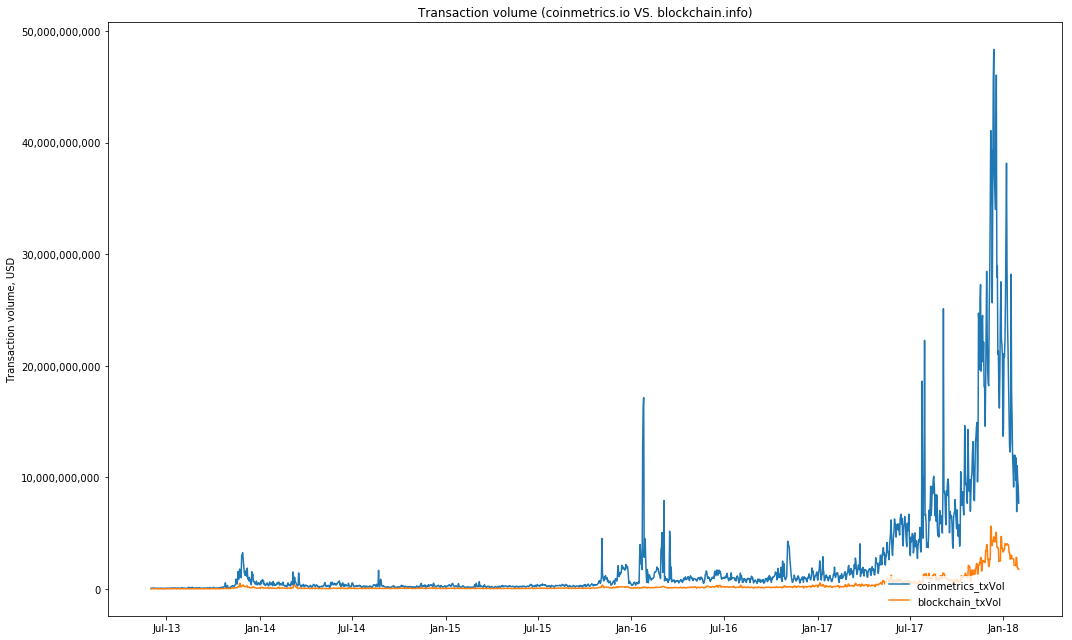

In [44]:
plt, ax = make_single_ts_plot(dates=comparison_df.index,
                              data_points=comparison_df.coinmetrics_txVol,
                              title='Transaction volume (coinmetrics.io VS. blockchain.info)',
                              ylabel='Transaction volume, USD',
                              y_log_scale=False)
plt.plot(comparison_df.index, comparison_df.blockchain_txVol)
legend = ax.legend(loc=4, bbox_to_anchor=(0.95, 0))
legend.get_frame().set_linewidth(0.0)
plt.show()

##### Определение *Transaction Volume (USD)*
На графике видны разительные отличия в объёмах транзакций. 

In [53]:
diffs = round((((
    comparison_df.coinmetrics_txVol
    .divide(comparison_df.blockchain_txVol, fill_value=0))-1) * 100)
    .describe()[['min', 'mean', 'max']], 
    2)
print(diffs)

min        24.82
mean      531.64
max     14741.46
dtype: float64


Разница между данными составляет от 24% до 14741%. Попытаемся выяснить в чём их причина, обратившись к определениям, которые дают сами источники.

*Blockchain.info:*
Для биткоина:
>The total estimated value of transactions on the Bitcoin blockchain (does not include coins returned to sender as change). __[link](https://blockchain.info/charts/estimated-transaction-volume?timespan=all)__

В долларовом выражении:
> The Estimated Transaction Value in USD value. __[link](https://blockchain.info/charts/estimated-transaction-volume-usd?timespan=all)__

*Coinmetrics.io:*
>That’s what we’re talking about when we say “on-chain transaction volume.” Simply put, it’s a broad and largely unadjusted measure of the total value of outputs on the blockchain, on a given day. This is an answer to the question “approximately how much value, denominated in USD, circulates on the Bitcoin blockchain a day?” 
That said, on-chain transaction volume in practice is a very hard thing to estimate properly. We discuss that at length in __[this post](https://coinmetrics.io/difficulty-estimating-chain-transaction-volume/)__. Please read it! We don’t want to give anyone a false degree of certainty in the number. We are currently working through various methods to improve the estimate, and maybe get closer to blockchain.info’s adjusted figure – but that will take time. So bear with us. __[link](https://coinmetrics.io/on-data-and-certainty/)__

Отлично! Оказывается об этом написали 19 января 2018г. в статье __[On the difficulty of estimating on-chain transaction volume](https://coinmetrics.io/difficulty-estimating-chain-transaction-volume/)__.

Вот, что авторы статьи пишут по поводу Transaction Value:
> Transaction volume in USD terms is highly unreliable and may be overstated by a factor of 5-10 or more.

### Вывод
Можно сделать вывод, что процесс выработки метрик для описания "пузырей" на рынке биткоина, которые бы объяснили то или иное явление усложняется многими факторами, в числе которых следующие:
* результат сильно зависит от источника исходных данных; 
* существуют споры о подходе к расчёту компонент метрик;
* исследователь в известной степени может быть подвержен необъективности.

В конце концов график или метрика могут лишь создавать впечатление того, что они что-то объясняют из-за особенностей визуализации среди которых:
* способ разделения диапазонов по признаку "высокое/среднее/низкое" значение;
* представление двух кривых на графике, где ось для одной из кривых отображена в логарифмичеком масштабе.

Здесь вполне уместна цитата из __[твита](https://twitter.com/el33th4xor/status/959413260670963712)__ профессора Корнеллского Университета Эмина Гюн Сиера:
> "Be wary of anyone who has an explanation. Disregard everyone who finds easy answers in charts. ..."

### Источники данных

* https://api.blockchain.info/charts/estimated-transaction-volume-usd?timespan=all&format=json
* https://api.blockchain.info/charts/market-cap?timespan=all&format=json
* https://api.blockchain.info/charts/market-price?timespan=all&format=json
* https://coinmetrics.io/data-downloads/


### Важные комментарии 
* https://medium.com/@l.ghidinelli/hi-dmitry-kalichkin-congratulations-for-this-amazing-study-dc66aad95e46
* https://medium.com/@dbektemissov/how-do-you-decide-how-to-assign-color-codes-to-specific-bands-of-ntv-levels-green-yellow-red-668b10374ed4
* https://medium.com/@robmahan/simply-wrong-i-am-afraid-e2f9ec084b03
* https://coinmetrics.io/on-data-and-certainty/